In [1]:
import pandas as pd
import re 
import warnings 

warnings.filterwarnings('ignore')

data = pd.read_csv('/home/liyan/Desktop/Capstone Project_II/Reviews.csv')
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch09_Analyzing_Wine_Types_and_Quality/model_evaluation_utils.py

In [2]:
# remove HelpfulnessDenominator that is less than 10
df = data[data.HelpfulnessDenominator >10]

In [3]:
# drop all na values
df = df.dropna()

In [4]:
# only select score and text as our dataframe
df = df.iloc[:, [6,9]]
df.head()

,Score,Text
32,4,McCann's Instant Oatmeal is great if you must ...
33,4,This is a good instant oatmeal from the best o...
82,5,I know the product title says Molecular Gastro...
158,5,"<span class=""tiny""> Length:: 0:26 Mins<br /><b..."
287,5,"This is a fantastic product, and I wish it was..."


In [5]:
# make sure the is no null value
df.isnull().sum()

Score    0
Text     0
dtype: int64

In [6]:
# reset index
df= df.reset_index()
df.head(2)

,index,Score,Text
0,32,4,McCann's Instant Oatmeal is great if you must ...
1,33,4,This is a good instant oatmeal from the best o...


In [7]:
# convert text to lower case
df.loc[:, 'Text'] = df['Text'].str.lower()

In [8]:
# remove punctuation 
import unicodedata
import sys

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)


In [9]:
#remove digits
from string import digits

def remove_digits(text):
    remove_digits = str.maketrans('', '', digits)
    return text.translate(remove_digits)


In [10]:
# Removing HTML tags
from bs4 import BeautifulSoup

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


In [11]:
# remove accented characters
import unicodedata 

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8','ignore')
    return text


In [12]:
# remove special characters

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


In [13]:
#download stopwords list
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/liyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#remove stop words
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [15]:
# combine all functions together 
def normalize_corpus(corpus, html_stripping=True,
                     accented_char_removal=True, 
                     special_char_removal=True, 
                        stopword_removal=True):
    
    #print("Corpus type: ", type(corpus))
    #print("Corpus length: ", len(corpus))
    
    normalized_corpus = []
    
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
        #doc = doc.to_string      
        
        normalized_corpus.append(doc)

    return normalized_corpus
        

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
#import model_evaluation_utils as meu

/home/liyan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


In [18]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
labels=level_labels)) 

    print(cm_frame)     

In [19]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
labels=classes) 
    print(report)

In [20]:
import numpy as np

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
classes=classes)

In [21]:

clean_text = normalize_corpus(df.Text)
clean_text


['mccanns instant oatmeal great must oatmeal scrape together two three minutes prepare no escaping fact however even best instant oatmeal nowhere near good even store brand oatmeal requiring stovetop preparation still mccanns good gets instant oatmeal even better organic allnatural brands tried varieties mccanns variety pack taste good prepared microwave adding boiling water convenient extreme time issue mccanns use actual cane sugar instead high fructose corn syrup helped decide buy product real sugar tastes better not harmful stuff one thing not like though mccanns use thickeners oats plus water plus heat make creamy tasty oatmeal without need guar gum convenience product maybe guar gum sitting bowl instant mccanns becomes thick gluey',
 'good instant oatmeal best oatmeal brand uses cane sugar instead high fructouse corn syrup not better sweetness doctors say form sugar better great cold morning dont time make mccanns steel cut oats apple cinnamon best maple brown sugar regular good 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  #Convert a collection of text documents to a matrix of token counts
X = vectorizer.fit_transform(clean_text) # a list of integers transformed from all text
y = df.Score


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30)

In [24]:
X

<21437x44755 sparse matrix of type '<class 'numpy.int64'>'
	with 1251129 stored elements in Compressed Sparse Row format>

In [25]:
doc_sum = X_train.toarray().sum(axis = 0) # The number of times each word is occuring over all the documents.
len_text = len(doc_sum) # number of unique words in all documents

In [26]:
import matplotlib.pyplot as plt
N = 80 
x_ax = np.arange(0,len_text)[:N] # [:N] changes this to only run for x_i values from 0 to 100 
y_ax = [sum(doc_sum <= i)/len_text for i in x_ax]# Determines the percentage values for y_i 

plt.plot(x_ax, y_ax) 
plt.xlabel('number of docs') 
plt.ylabel('% of words') 
plt.title('% of Words That Appear In <= X Documents, N = 80')


Text(0.5,1,'% of Words That Appear In <= X Documents, N = 80')

In [27]:
#sklearn.feature_extraction.text.TfidfVectorizer¶ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [28]:
X.shape

(21437, 44755)

In [29]:
X_train.shape

(15005, 44755)

In [30]:
train_docs, test_docs, y_train, y_test = train_test_split(np.array(clean_text), y, test_size= 0.30)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=5, max_df=1.0, use_idf=True)
X_train = tv.fit_transform(train_docs)
X_test = tv.transform(test_docs)

In [32]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB().fit(X_train, y_train)
# MultinomialNB() is for classification with dicrete features. In this case, freshness and text in integers.
print ('Accuracy on training set: {}'.format(clf_nb.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_nb.score(X_test, y_test)))

Accuracy on training set: 0.6767744085304899
Accuracy on testing set:  0.6559390547263682


In [33]:
y_pred = clf_nb.predict(X_test)
y_pred

array([5, 5, 5, ..., 5, 5, 5])

In [34]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.6559
Precision: 0.7426
Recall: 0.6559
F1 Score: 0.5752

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.76      0.63      0.69      1873
          2       0.92      0.05      0.09       474
          3       1.00      0.00      0.00       480
          4       1.00      0.03      0.07       534
          5       0.62      0.97      0.76      3071

avg / total       0.74      0.66      0.58      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                 
                   1   2  3   4     5
Actual: 1       1189   0  0   0   684
        2        138  22  0   0   314
        3        115   0  1   0   364
        4         39   0  0  18   477
        5         80   2  0   0  2989


In [35]:
# multiple logistics regression 

clf_log = LogisticRegression(random_state= 1, max_iter=2000, 
                                multi_class='ovr', 
                                #n_jobs=4, 
                                solver='newton-cg',penalty='l2',
                                class_weight='balanced'
                                )

In [36]:
clf_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=2000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [37]:
X.shape

(21437, 44755)

In [38]:
y_pred = clf_log.predict(X_test)

In [39]:
print ('Accuracy on training set: {}'.format(clf_log.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_log.score(X_test, y_test)))

Accuracy on training set: 0.8740419860046651
Accuracy on testing set:  0.7189054726368159


In [40]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7189
Precision: 0.7207
Recall: 0.7189
F1 Score: 0.7197

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.77      0.79      0.78      1873
          2       0.42      0.43      0.42       474
          3       0.42      0.42      0.42       480
          4       0.39      0.39      0.39       534
          5       0.84      0.82      0.83      3071

avg / total       0.72      0.72      0.72      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1478  130   83   44   138
        2        127  206   59   31    51
        3         99   50  203   50    78
        4         51   29   43  206   205
        5        167   81   98  194  2531


Model training: Naive bayes, logistic regression, SVM, decision tree, random forest, gradient boosting

In [41]:
#SVM
import numpy as np
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

clf_svc = LinearSVC(C=1)
clf_svc_model = clf_svc.fit(X_train, y_train)

y_c = clf_svc_model.predict(X_test)

In [42]:
print ('Accuracy on training set: {}'.format(clf_svc_model.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_svc_model.score(X_test, y_test)))

Accuracy on training set: 0.9514828390536488
Accuracy on testing set:  0.7545087064676617


In [43]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_c, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7545
Precision: 0.7354
Recall: 0.7545
F1 Score: 0.7376

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.76      0.83      0.79      1873
          2       0.57      0.40      0.47       474
          3       0.59      0.36      0.45       480
          4       0.54      0.31      0.40       534
          5       0.80      0.90      0.85      3071

avg / total       0.74      0.75      0.74      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1549   65   37   24   198
        2        160  190   28   12    84
        3        123   26  175   33   123
        4         62   15   21  168   268
        5        152   39   36   73  2771


In [44]:
#decision tree
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Fit regression model
clf_1 = DecisionTreeClassifier(max_depth=68)
clf_2 = DecisionTreeClassifier(max_depth=5)
clf_1.fit(X_train, y_train)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
print ('Accuracy on training set: {}'.format(clf_1.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_1.score(X_test, y_test)))

Accuracy on training set: 0.9617460846384539
Accuracy on testing set:  0.6764614427860697


In [46]:
print ('Accuracy on training set: {}'.format(clf_2.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_2.score(X_test, y_test)))

Accuracy on training set: 0.5206264578473841
Accuracy on testing set:  0.5073072139303483


In [47]:
y_1 = clf_1.predict(X_test)
y_2 = clf_2.predict(X_test)

In [48]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_1, 
                                      classes=[1,2,3,4,5])


Model Performance metrics:
------------------------------
Accuracy: 0.6765
Precision: 0.6641
Recall: 0.6765
F1 Score: 0.6672

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.66      0.73      0.70      1873
          2       0.50      0.40      0.44       474
          3       0.51      0.36      0.42       480
          4       0.48      0.35      0.41       534
          5       0.75      0.79      0.77      3071

avg / total       0.66      0.68      0.67      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1366   77   45   44   341
        2        124  188   18   24   120
        3        114   19  172   24   151
        4         88   20   17  189   220
        5        364   75   83  113  2436


In [49]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_2, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.5073
Precision: 0.5406
Recall: 0.5073
F1 Score: 0.3794

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.72      0.12      0.20      1873
          2       0.62      0.01      0.02       474
          3       0.00      0.00      0.00       480
          4       0.59      0.03      0.06       534
          5       0.50      0.99      0.66      3071

avg / total       0.54      0.51      0.38      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                
                   1  2  3   4     5
Actual: 1        216  2  0   4  1651
        2         24  5  0   0   445
        3         16  1  0   0   463
        4          8  0  0  16   510
        5         38  0  0   7  3026


In [50]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
import numpy as np

clf_rf = RandomForestClassifier(random_state=1)
clf_rf.fit(X_train, y_train)

feature_names = tv.get_feature_names()

clf_rf_feature_importances = clf_rf.feature_importances_
clf_rf_feature_names, clf_rf_feature_scores = zip(*sorted(zip(feature_names, clf_rf_feature_importances), 
                                                          key=lambda x: -x[1]))


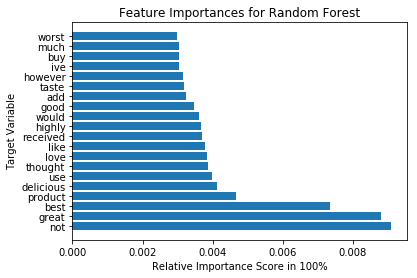

In [51]:
import matplotlib.pyplot as plt
#y_position = list(range(len(clf_rf_feature_names)))
plt.barh(clf_rf_feature_names[:20], clf_rf_feature_scores[:20])
#plt.yticks(clf_rf_feature_names, y_position)
plt.xlabel('Relative Importance Score in 100%')
plt.ylabel('Target Variable')
t = plt.title('Feature Importances for Random Forest')

In [52]:
y_pred = clf_rf.predict(X_test)

In [53]:
print ('Accuracy on training set: {}'.format(clf_rf.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_rf.score(X_test, y_test)))

Accuracy on training set: 0.9906031322892369
Accuracy on testing set:  0.7444029850746269


In [54]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7444
Precision: 0.7738
Recall: 0.7444
F1 Score: 0.7191

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.72      0.79      0.75      1873
          2       0.92      0.35      0.51       474
          3       0.90      0.31      0.46       480
          4       0.95      0.30      0.45       534
          5       0.73      0.92      0.82      3071

avg / total       0.77      0.74      0.72      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1477    4    6    3   383
        2        144  166    0    1   163
        3        141    1  149    1   188
        4         77    4    1  159   293
        5        216    5   10    3  2837


In [55]:
# feature importance, sklearn.linear_model.SGDClassifier after PCA only for svc
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [56]:
# Gradient Boosting
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators':100, 'max_depth': None, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

params = {'n_estimators':100}

clf_gb = ensemble.GradientBoostingClassifier(**params)

clf_gb.fit(X_train, y_train)

feature_names = tv.get_feature_names()

clf_gb_feature_importances = clf_gb.feature_importances_
clf_gb_feature_names, clf_gb_feature_scores = zip(*sorted(zip(feature_names, clf_gb_feature_importances), 
                                                          key=lambda x: - x[1]))


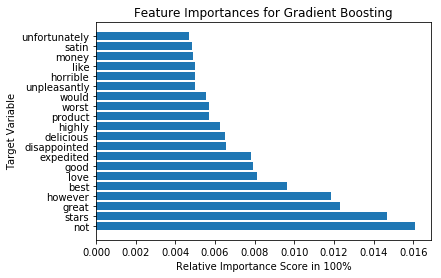

In [57]:
#y_position = list(range(len(clf_rf_feature_names)))
plt.barh(clf_gb_feature_names[:20], clf_gb_feature_scores[:20])
#plt.yticks(clf_rf_feature_names, y_position)
plt.xlabel('Relative Importance Score in 100%')
plt.ylabel('Target Variable')
t = plt.title('Feature Importances for Gradient Boosting')

In [58]:
y_pred = clf_gb.predict(X_test)

In [59]:
print ('Accuracy on training set: {}'.format(clf_gb.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_gb.score(X_test, y_test)))

Accuracy on training set: 0.7347550816394535
Accuracy on testing set:  0.6935634328358209


In [60]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.6936
Precision: 0.722
Recall: 0.6936
F1 Score: 0.6455

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.72      0.69      0.71      1873
          2       0.89      0.17      0.29       474
          3       0.82      0.15      0.26       480
          4       0.76      0.17      0.28       534
          5       0.67      0.95      0.79      3071

avg / total       0.72      0.69      0.65      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                  
                   1   2   3   4     5
Actual: 1       1301   4   6   4   558
        2        173  81   2   4   214
        3        136   2  73   8   261
        4         54   2   0  90   388
        5        133   2   8  12  2916


In [61]:
# SGDC classifier
from sklearn import linear_model

clf_sgdc = linear_model.SGDClassifier()
clf_sgdc.fit(X_train, y_train)
y_pred = clf_sgdc.predict(X_test)


In [62]:
print ('Accuracy on training set: {}'.format(clf_sgdc.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(clf_sgdc.score(X_test, y_test)))

Accuracy on training set: 0.8381872709096968
Accuracy on testing set:  0.7476679104477612


In [63]:
display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7477
Precision: 0.7416
Recall: 0.7477
F1 Score: 0.7114

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.72      0.85      0.78      1873
          2       0.76      0.26      0.38       474
          3       0.67      0.25      0.36       480
          4       0.71      0.21      0.32       534
          5       0.77      0.93      0.84      3071

avg / total       0.74      0.75      0.71      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1588   16   14    8   247
        2        211  122   17    7   117
        3        161   10  118   13   178
        4         69    4   15  111   335
        5        163    8   12   18  2870


In [64]:
# hyperparameter tuning linear svc, random forests, and SGDClassifier

In [65]:
# LinearSVC
from sklearn.model_selection import GridSearchCV

svc_params_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_cv_svc = GridSearchCV(clf_svc, svc_params_grid, n_jobs=4, cv=5, return_train_score=True)

In [66]:
clf_svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [67]:
grid_cv_svc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [68]:
print("R-Squared::{}".format(grid_cv_svc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_svc.best_params_))

R-Squared::0.76107964011996
Best Hyperparameters::
{'C': 1}


In [69]:
print ('Accuracy on training set: {}'.format(grid_cv_svc.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(grid_cv_svc.score(X_test, y_test)))

Accuracy on training set: 0.9514828390536488
Accuracy on testing set:  0.7545087064676617


In [70]:
y_pred = grid_cv_svc.predict(X_test)

display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7545
Precision: 0.7354
Recall: 0.7545
F1 Score: 0.7376

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.76      0.83      0.79      1873
          2       0.57      0.40      0.47       474
          3       0.59      0.36      0.45       480
          4       0.54      0.31      0.40       534
          5       0.80      0.90      0.85      3071

avg / total       0.74      0.75      0.74      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1549   65   37   24   198
        2        160  190   28   12    84
        3        123   26  175   33   123
        4         62   15   21  168   268
        5        152   39   36   73  2771


In [71]:
# SGDClassifier

sgdc_params_grid = {"penalty": ['l1','l2','elasticnet']
                   #"l1_ratio": [0.2, 0.5, 0.7]
                   }

grid_cv_sgdc = GridSearchCV(clf_sgdc, sgdc_params_grid, n_jobs=4, cv=5, return_train_score=True)

In [72]:
grid_cv_sgdc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
print("R-Squared::{}".format(grid_cv_sgdc.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_sgdc.best_params_))

R-Squared::0.746484505164945
Best Hyperparameters::
{'penalty': 'l2'}


In [74]:
print ('Accuracy on training set: {}'.format(grid_cv_sgdc.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(grid_cv_sgdc.score(X_test, y_test)))

Accuracy on training set: 0.8409196934355215
Accuracy on testing set:  0.7492226368159204


In [75]:
y_pred = grid_cv_sgdc.predict(X_test)

display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7492
Precision: 0.7429
Recall: 0.7492
F1 Score: 0.7145

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.73      0.84      0.78      1873
          2       0.74      0.28      0.40       474
          3       0.73      0.25      0.37       480
          4       0.68      0.22      0.33       534
          5       0.76      0.94      0.84      3071

avg / total       0.74      0.75      0.71      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1576   16   12   10   259
        2        208  132   14    7   113
        3        148   16  118   17   181
        4         64    4    8  118   340
        5        153   11   10   22  2875


In [76]:
#random forests

rf_param_grid = {'n_estimators': [200],
              #"criterion": ["mse"],
              #"min_samples_split": [2, 3],
              #"max_features": ['auto','log2', None]
              #"max_depth": [3, 4],
              #"min_samples_leaf": [10, 20, 30],
              #"max_leaf_nodes": [20,40,60]
             }

grid_cv_rf = GridSearchCV(clf_rf, rf_param_grid, n_jobs=1, cv=5, return_train_score=True)

In [77]:
grid_cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [78]:
print("R-Squared::{}".format(grid_cv_rf.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_rf.best_params_))

R-Squared::0.7559480173275575
Best Hyperparameters::
{'n_estimators': 200}


In [79]:
print ('Accuracy on training set: {}'.format(grid_cv_rf.score(X_train, y_train)))
print ('Accuracy on testing set:  {}'.format(grid_cv_rf.score(X_test, y_test)))

Accuracy on training set: 1.0
Accuracy on testing set:  0.7657027363184079


In [80]:
y_pred = grid_cv_rf.predict(X_test)

display_model_performance_metrics(true_labels= y_test, predicted_labels= y_pred, 
                                      classes=[1,2,3,4,5])

Model Performance metrics:
------------------------------
Accuracy: 0.7657
Precision: 0.811
Recall: 0.7657
F1 Score: 0.7385

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          1       0.81      0.78      0.79      1873
          2       1.00      0.35      0.52       474
          3       1.00      0.31      0.48       480
          4       1.00      0.30      0.46       534
          5       0.72      0.97      0.83      3071

avg / total       0.81      0.77      0.74      6432


Prediction Confusion Matrix:
------------------------------
          Predicted:                     
                   1    2    3    4     5
Actual: 1       1456    0    0    0   417
        2        120  165    0    0   189
        3        102    0  151    0   227
        4         37    0    0  161   336
        5         79    0    0    0  2992
